In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 7.1MB/s 


In [2]:
# Import modules
# Add modules as needed
from sklearn.datasets import fetch_openml
import numpy as np
from numpy import expand_dims
from sklearn.model_selection import train_test_split

# For windows laptops add following 2 lines:
import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import os
import random as rn
import cv2
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.utils.np_utils import to_categorical
import kerastuner as kt

In [3]:
#load pothole image data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/DL_Project/PotholesPascalVOC.zip'

Archive:  /content/drive/MyDrive/DL_Project/PotholesPascalVOC.zip
   creating: images/
  inflating: images/potholes87.png   
   creating: __MACOSX/
   creating: __MACOSX/images/
  inflating: __MACOSX/images/._potholes87.png  
  inflating: images/potholes297.png  
  inflating: __MACOSX/images/._potholes297.png  
  inflating: images/potholes93.png   
  inflating: __MACOSX/images/._potholes93.png  
  inflating: images/potholes283.png  
  inflating: __MACOSX/images/._potholes283.png  
  inflating: images/potholes78.png   
  inflating: __MACOSX/images/._potholes78.png  
  inflating: images/potholes268.png  
  inflating: __MACOSX/images/._potholes268.png  
  inflating: images/potholes532.png  
  inflating: __MACOSX/images/._potholes532.png  
  inflating: images/potholes44.png   
  inflating: __MACOSX/images/._potholes44.png  
  inflating: images/potholes254.png  
  inflating: __MACOSX/images/._potholes254.png  
  inflating: images/potholes50.png   
  inflating: __MACOSX/images/._potholes50.p

In [5]:
!unzip '/content/drive/MyDrive/DL_Project/Roadnopotholesimages.zip'

Archive:  /content/drive/MyDrive/DL_Project/Roadnopotholesimages.zip
   creating: Road no potholes images/
  inflating: Road no potholes images/image691.png  
  inflating: __MACOSX/Road no potholes images/._image691.png  
  inflating: Road no potholes images/image108.png  
  inflating: __MACOSX/Road no potholes images/._image108.png  
  inflating: Road no potholes images/image120.png  
  inflating: __MACOSX/Road no potholes images/._image120.png  
  inflating: Road no potholes images/image646.png  
  inflating: __MACOSX/Road no potholes images/._image646.png  
  inflating: Road no potholes images/image134.png  
  inflating: __MACOSX/Road no potholes images/._image134.png  
  inflating: Road no potholes images/image487.png  
  inflating: __MACOSX/Road no potholes images/._image487.png  
  inflating: Road no potholes images/image444.png  
  inflating: __MACOSX/Road no potholes images/._image444.png  
  inflating: Road no potholes images/image322.png  
  inflating: __MACOSX/Road no pothol

In [6]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
              
def assign_label(img,label):
    return label

In [7]:
X=[]
Z=[]
IMG_SIZE=250

normal='../content/Road no potholes images/'
potholes='../content/images/'

make_train_data('NORMAL',normal)
make_train_data('POTHOLES',potholes)

100%|██████████| 665/665 [00:06<00:00, 99.16it/s]


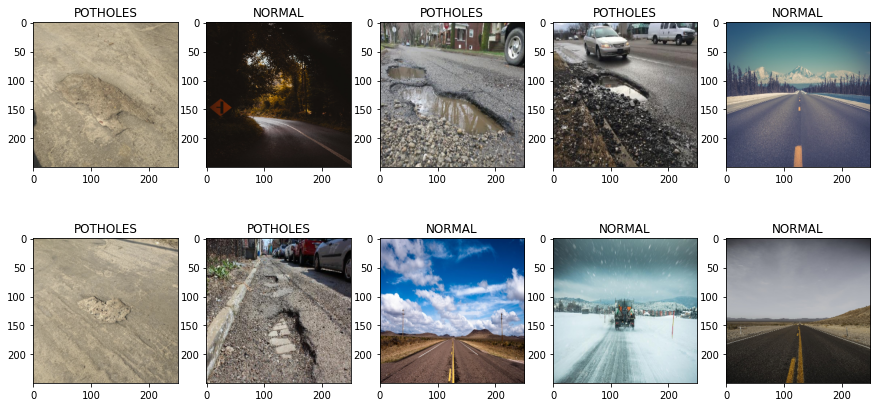

In [8]:
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

# ax[1,1].imshow(X[789][:,:,::-1])
# ax[1,1].set_title(Z[789])

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)
X=X/255

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.15, random_state=42)

#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.15, random_state=42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
#print(X_val.shape)

(1240, 250, 250, 3)
(1054, 250, 250, 3)
(186, 250, 250, 3)


In [11]:
# Build Model

def model_builder(hp):
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (250, 250, 3)))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  
  model.add(keras.layers.Dense(2,  activation = "sigmoid"))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = hp_learning_rate), metrics=['accuracy'])

  model.summary()

  return model

# model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256, activation = "relu"))
# model.add(Dropout(0.25))
# model.add(Dense(2, activation = "sigmoid"))


In [12]:
tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=50,
                     factor=3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0

In [15]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.25)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 63 Complete [00h 00m 07s]
accuracy: 0.5164557099342346

Best accuracy So Far: 1.0
Total elapsed time: 00h 41m 23s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 and the optimal learning rate for the optimizer
is 0.001.



In [19]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0

In [20]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, Y_train, epochs=best_epoch, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0

In [21]:
# evaluate model

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss: {:.3f}, Test Accuracy: {:.3f}".format(test_loss, test_accuracy))


6/6 [==============================] - 0s 12ms/step - loss: 0.3295 - accuracy: 0.9194
Test Loss: 0.330, Test Accuracy: 0.919


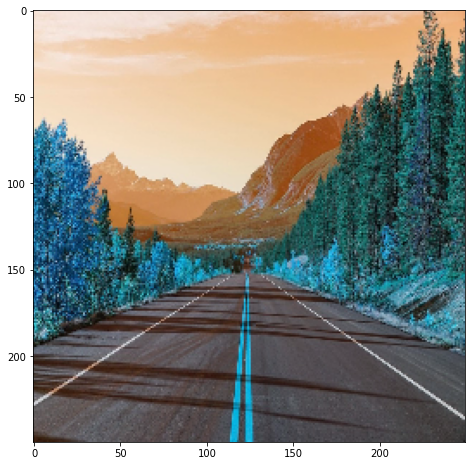

In [59]:
# import random image

test_path = '../content/test_image.jpg'

test_img = cv2.imread(test_path,cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (IMG_SIZE,IMG_SIZE))

fig1,ay=plt.subplots(1,1)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig1.set_size_inches(15,15)

ay.imshow(test_img)

In [60]:

test_img_dim = expand_dims(test_img, axis=0)

test_img_dim.shape

(1, 250, 250, 3)

In [61]:
# predict class of random image

y_pred = model.predict(test_img_dim)

print(y_pred)

prediction = y_pred.argmax()

print(prediction)

p = le.inverse_transform([prediction])

print("This image is",str(p[0]))

[[1. 0.]]
0
This image is NORMAL
